# US Stock Portfolio Analysis

해외주식 포트폴리오 분석 노트북

이 노트북은 다음 분석을 제공합니다:
1. 오늘 매도한 종목 분석
2. 포트폴리오 보유 비중 파이 차트
3. 보유 종목별 수익률/홀딩기간 막대 차트
4. 포트폴리오 vs S&P500/NASDAQ 수익률 비교 (TWR/MWR)
5. 요약 테이블

In [32]:
import sys
import warnings
from pathlib import Path
from datetime import datetime, date, timedelta
from zoneinfo import ZoneInfo

# Suppress pandas SQLAlchemy warning (pymysql works fine)
warnings.filterwarnings('ignore', message='.*pandas only supports SQLAlchemy.*')

# Add project root to path
PROJECT_ROOT = Path().absolute().parent
sys.path.insert(0, str(PROJECT_ROOT))

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from decimal import Decimal

from db.connection import get_connection

# US Eastern timezone
ET = ZoneInfo("America/New_York")

def get_trading_date_et() -> date:
    """
    Get the current US trading date (Eastern Time).
    - Before 8 PM ET: current US date
    - After 8 PM ET: next trading day
    """
    now_et = datetime.now(ET)
    if now_et.hour >= 20:
        target = (now_et + timedelta(days=1)).date()
    else:
        target = now_et.date()
    # Skip weekends
    while target.weekday() >= 5:
        target += timedelta(days=1)
    return target

# Set Korean font for matplotlib (if available)
try:
    plt.rcParams['font.family'] = 'Malgun Gothic'
except:
    pass
plt.rcParams['axes.unicode_minus'] = False

# Get database connection
conn = get_connection()

# Use ET date for trading
today_et = get_trading_date_et()
today_kst = date.today()
now_et = datetime.now(ET)

print(f"Connected to database")
print(f"  KST 날짜: {today_kst}")
print(f"  US ET 날짜: {today_et}")
print(f"  US ET 시간: {now_et.strftime('%Y-%m-%d %H:%M:%S')}")

Connected to database
  KST 날짜: 2026-02-21
  US ET 날짜: 2026-02-23
  US ET 시간: 2026-02-21 08:48:12


## 1. 오늘 매도한 종목 (Sold Stocks Today)

오늘 매도한 종목들의 실현 수익률과 보유 기간을 분석합니다.

In [ ]:
# Query sold stocks - 마지막 거래일 기준 (today_et가 주말/다음영업일로 넘어간 경우 대비)
with conn.cursor() as cur:
    cur.execute(
        "SELECT MAX(snapshot_date) FROM daily_portfolio_snapshot WHERE snapshot_date <= %s",
        (today_et,)
    )
    last_trading_day = cur.fetchone()[0] or today_et

sold_query = """
SELECT 
    stock_code,
    stock_name,
    currency,
    trade_date as buy_date,
    closed_date as sell_date,
    net_quantity as quantity,
    avg_purchase_price as buy_price,
    current_price as sell_price,
    total_cost,
    realized_pnl,
    holding_days,
    CASE WHEN total_cost > 0 
         THEN (realized_pnl / total_cost) * 100 
         ELSE 0 END as realized_return_pct
FROM daily_lots
WHERE is_closed = TRUE AND closed_date = %s
ORDER BY realized_pnl DESC
"""

sold_df = pd.read_sql(sold_query, conn, params=(last_trading_day,))

print(f"{last_trading_day} 매도 종목: {len(sold_df)}건")
print()

columns = ['종목코드', '종목명', '매수가(USD)', '매도가(USD)', '수익률', '보유일']

if sold_df.empty:
    # 헤더는 유지하고 "매도 종목 없음" 표시
    from IPython.display import HTML
    header_html = '<table style="text-align:center; margin:auto; border-collapse:collapse;">'
    header_html += '<thead><tr>' + ''.join(
        f'<th style="padding:8px 16px; border-bottom:2px solid #ddd; font-weight:bold;">{c}</th>'
        for c in columns
    ) + '</tr></thead>'
    header_html += '<tbody><tr><td colspan="6" style="padding:20px; color:#888; font-size:14px;">매도 종목 없음</td></tr></tbody>'
    header_html += '</table>'
    display(HTML(header_html))

    # PNG용 styled DataFrame
    empty_df = pd.DataFrame({c: ['매도 종목 없음' if c == '종목명' else ''] for c in columns}, index=[0])
    df_styled = (
        empty_df.style
        .hide(axis='index')
        .set_properties(**{'text-align': 'center', 'color': '#888'})
    )
else:
    display_df = sold_df[['stock_code', 'stock_name', 'buy_price', 'sell_price',
                         'realized_return_pct', 'holding_days']].copy()
    display_df.columns = columns
    display_df['보유일'] = display_df['보유일'].apply(lambda x: f"{int(x)}일" if pd.notna(x) else "-")

    df_styled = (
        display_df.style
        .format({
            '매수가(USD)': '${:,.2f}',
            '매도가(USD)': '${:,.2f}',
            '수익률': '{:+.2f}%',
        })
        .hide(axis='index')
        .set_properties(**{'text-align': 'center'})
        .background_gradient(subset=['수익률'], cmap='RdYlGn', vmin=-10, vmax=10)
    )

    display(df_styled)

    total_pnl = sold_df['realized_pnl'].sum()
    avg_return = sold_df['realized_return_pct'].mean()
    avg_holding = sold_df['holding_days'].mean()
    print(f"\n총 실현손익: ${total_pnl:+,.2f}")
    print(f"평균 수익률: {avg_return:+.2f}%")
    print(f"평균 보유일: {avg_holding:.1f}일")

# PNG 저장 (매도 유무 관계없이 항상)
try:
    import dataframe_image as dfi
    output_dir = PROJECT_ROOT / 'output'
    output_dir.mkdir(exist_ok=True)
    png_path = output_dir / f"sold_{last_trading_day}.png"
    dfi.export(df_styled, str(png_path), table_conversion="matplotlib", dpi=200)
    print(f"\nSaved: {png_path}")
except ImportError:
    print("dataframe_image not installed. Run: pip install dataframe_image")

## 2. 포트폴리오 보유 비중 (Portfolio Weight Pie Chart)

Snapshot date (기준일): 2026-02-20
Trading date (US ET): 2026-02-23
Last trade date: 2026-02-18 (최근 매매일 기준으로 표시)
최근(2026-02-18) 매수 종목: {'SNXX', 'SIMO'}
전일 보유 종목 (이전 매수): {'GEV', 'GLW', 'LITE', 'VRT', 'EVMN', 'SIMO'}

[외화잔고 계산]
  외화주문가능금액: $160.60
  주식평가액: $27,914.46
  총 자산 (외화잔고): $28,075.06

총 포트폴리오 가치: $28,075.06
보유 종목: 7개 (신규진입: 1개, 추가매수: 1개)



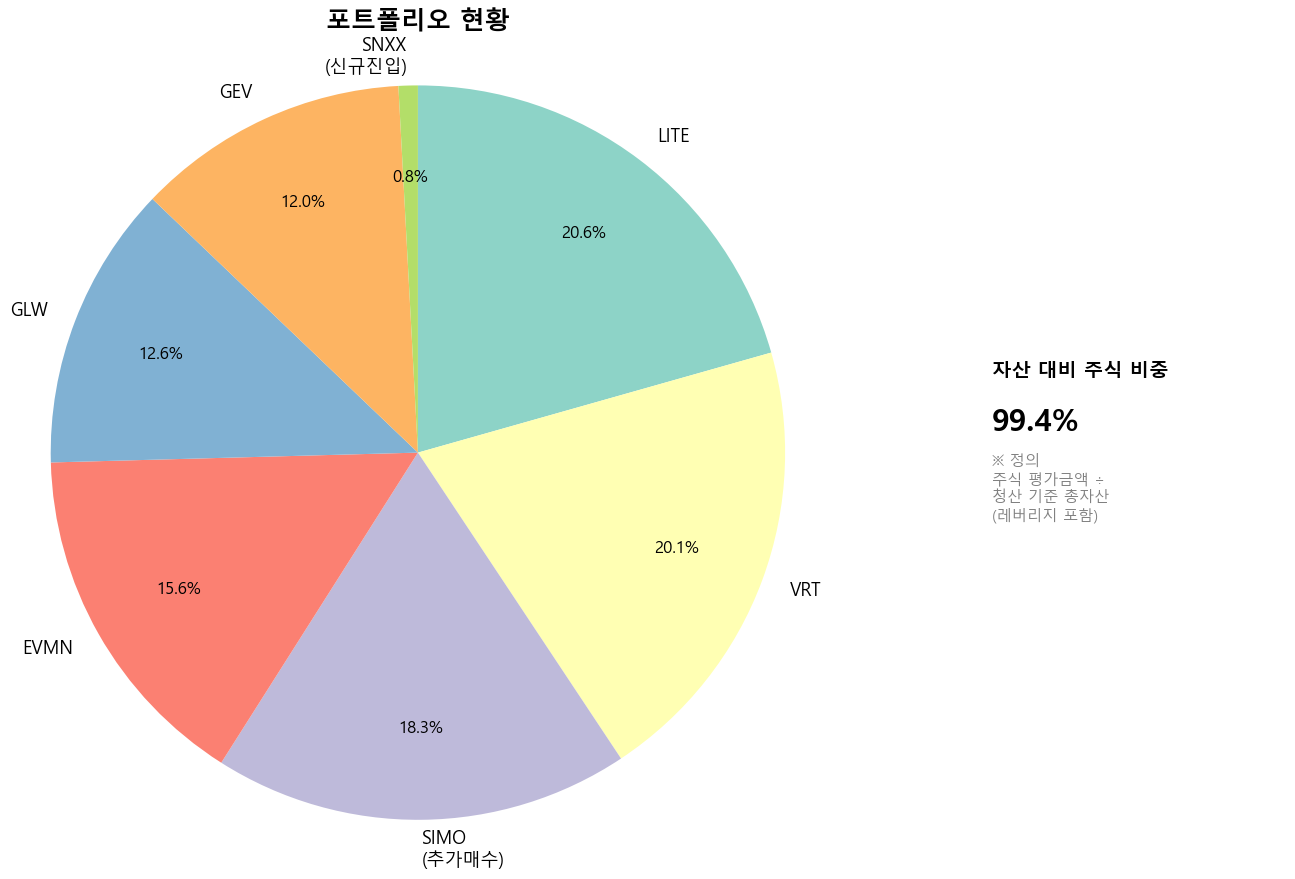

In [24]:
# Query current portfolio composition with today's buy info
# Get the latest snapshot date
with conn.cursor() as cur:
    cur.execute("SELECT MAX(snapshot_date) FROM portfolio_snapshot")
    snapshot_date = cur.fetchone()[0]

    # 최근 매매일 자동 탐색 (today_et가 다음 영업일로 넘어간 경우 대비)
    cur.execute(
        "SELECT MAX(trade_date) FROM account_trade_history WHERE trade_date <= %s",
        (today_et,)
    )
    last_trade_date = cur.fetchone()[0] or today_et

print(f"Snapshot date (기준일): {snapshot_date}")
print(f"Trading date (US ET): {today_et}")
if last_trade_date != today_et:
    print(f"Last trade date: {last_trade_date} (최근 매매일 기준으로 표시)")

# 최근 매매일 기준으로 매수 종목 확인
today_buys_query = """
SELECT DISTINCT stk_cd
FROM account_trade_history
WHERE trade_date = %s AND io_tp_nm LIKE '%%매수%%'
"""

# 전일 보유 종목 (daily_lots에서 trade_date < 최근매매일인 종목 = 그 전에 산 것)
prev_holdings_query = """
SELECT DISTINCT stock_code
FROM daily_lots
WHERE is_closed = FALSE AND trade_date < %s
"""

portfolio_query = """
SELECT
    ps.stock_code,
    ps.stock_name,
    ps.market_value,
    ps.portfolio_weight_pct,
    ps.unrealized_return_pct,
    ps.total_portfolio_value
FROM portfolio_snapshot ps
WHERE ps.snapshot_date = %s
ORDER BY ps.portfolio_weight_pct DESC
"""

# Execute queries - last_trade_date 기준으로 매수 확인
today_buys_df = pd.read_sql(today_buys_query, conn, params=(last_trade_date,))
today_buy_symbols = set(today_buys_df['stk_cd'].tolist())

prev_holdings_df = pd.read_sql(prev_holdings_query, conn, params=(last_trade_date,))
prev_holding_symbols = set(prev_holdings_df['stock_code'].tolist())

portfolio_df = pd.read_sql(portfolio_query, conn, params=(snapshot_date,))

print(f"최근({last_trade_date}) 매수 종목: {today_buy_symbols if today_buy_symbols else '없음'}")
print(f"전일 보유 종목 (이전 매수): {prev_holding_symbols}")

if portfolio_df.empty:
    print("포트폴리오 스냅샷 데이터가 없습니다.")
else:
    # 총 자산 계산: 외화주문가능금액 + 주식평가액 (외화잔고 개념)
    # 1. 외화주문가능금액 from API
    try:
        from services.kis_service import KISAPIClient
        import requests
        
        client = KISAPIClient()
        url = f"{client.base_url}/uapi/overseas-stock/v1/trading/inquire-psamount"
        headers = client._get_headers("TTTS3007R")
        params = {
            "CANO": client.cano,
            "ACNT_PRDT_CD": client.acnt_prdt_cd,
            "OVRS_EXCG_CD": "NASD",
            "OVRS_ORD_UNPR": "100",
            "ITEM_CD": "AAPL",
        }
        client._wait_for_rate_limit()
        response = requests.get(url, headers=headers, params=params)
        data = response.json()
        output = data.get("output", {})
        cash_available = float(output.get("ord_psbl_frcr_amt", 0) or 0)
    except Exception as e:
        print(f"[WARN] API 현금조회 실패: {e}")
        cash_available = 0
    
    # 2. 주식평가액 from holdings
    with conn.cursor() as cur:
        cur.execute("""
            SELECT COALESCE(SUM(evlt_amt), 0)
            FROM holdings
            WHERE snapshot_date = (SELECT MAX(snapshot_date) FROM holdings)
        """)
        stock_value = float(cur.fetchone()[0] or 0)
    
    # 총 자산 = 외화주문가능금액 + 주식평가액
    total_value = cash_available + stock_value
    total_stock_value = portfolio_df['market_value'].sum()
    stock_exposure_pct = (total_stock_value / total_value * 100) if total_value > 0 else 0

    print(f"\n[외화잔고 계산]")
    print(f"  외화주문가능금액: ${cash_available:,.2f}")
    print(f"  주식평가액: ${stock_value:,.2f}")
    print(f"  총 자산 (외화잔고): ${total_value:,.2f}")

    # 라벨 결정: 신규진입 / 추가매수 / 없음
    def get_label(row):
        symbol = row['stock_code'].upper()
        is_today_buy = symbol in today_buy_symbols
        was_prev_held = symbol in prev_holding_symbols

        if is_today_buy and was_prev_held:
            return f"{symbol}\n(추가매수)"
        elif is_today_buy and not was_prev_held:
            return f"{symbol}\n(신규진입)"
        else:
            return symbol

    portfolio_df["display_name"] = portfolio_df.apply(get_label, axis=1)

    new_buy_count = sum(1 for s in portfolio_df['stock_code'] if s in today_buy_symbols and s not in prev_holding_symbols)
    add_buy_count = sum(1 for s in portfolio_df['stock_code'] if s in today_buy_symbols and s in prev_holding_symbols)

    print(f"\n총 포트폴리오 가치: ${total_value:,.2f}")
    print(f"보유 종목: {len(portfolio_df)}개 (신규진입: {new_buy_count}개, 추가매수: {add_buy_count}개)")
    print()

    # Recalculate weight based on correct total_value
    portfolio_df['weight_pct'] = (portfolio_df['market_value'] / total_value * 100) if total_value > 0 else 0

    # Pie chart with right text panel (like asset project)
    fig = plt.figure(figsize=(14, 9))
    ax_pie = fig.add_axes([0.02, 0.05, 0.68, 0.85])  # 파이 차트 영역
    ax_text = fig.add_axes([0.70, 0.30, 0.28, 0.40])  # 우측 텍스트 영역

    # Group small positions as 'Others' (only if 2+ stocks are below threshold)
    threshold = 3.0  # 3% 미만은 기타로 묶음
    main_positions = portfolio_df[portfolio_df['weight_pct'] >= threshold]
    others = portfolio_df[portfolio_df['weight_pct'] < threshold]

    if len(others) >= 2:
        # 2개 이상이면 기타로 묶음
        labels = list(main_positions['display_name'])
        sizes = list(main_positions['weight_pct'])
    else:
        # 1개 이하면 그대로 표시
        labels = list(portfolio_df['display_name'])
        sizes = list(portfolio_df['weight_pct'])
        others = pd.DataFrame()  # 기타 없음

    # 현금 비중 추가
    cash_weight = (cash_available / total_value * 100) if total_value > 0 else 0
    if cash_weight >= threshold:
        labels.append('현금')
        sizes.append(cash_weight)

    if not others.empty:
        labels.append('기타')
        sizes.append(others['weight_pct'].sum())

    # Colors
    colors = plt.cm.Set3(range(len(labels)))

    wedges, texts, autotexts = ax_pie.pie(
        sizes,
        labels=labels,
        autopct='%1.1f%%',
        colors=colors,
        startangle=90,
        counterclock=False,
        radius=1.2,
        labeldistance=1.08,
        pctdistance=0.75
    )

    # 폰트 크기 증가
    for t in texts:
        t.set_fontsize(13)  # 티커 폰트 크기 증가
    for t in autotexts:
        t.set_fontsize(12)  # 비중 폰트 크기 증가

    ax_pie.set_title('포트폴리오 현황', fontsize=18, fontweight='bold', pad=30)

    # 우측 텍스트 패널
    ax_text.axis("off")
    ax_text.text(0.25, 0.65, "자산 대비 주식 비중", fontsize=14, fontweight="bold")
    ax_text.text(0.25, 0.50, f"{stock_exposure_pct:.1f}%", fontsize=22, fontweight="bold")
    disclaimer = "\u203b \uc815\uc758\n\uc8fc\uc2dd \ud3c9\uac00\uae08\uc561 \u00f7\n\uccad\uc0b0 \uae30\uc900 \ucd1d\uc790\uc0b0\n(\ub808\ubc84\ub9ac\uc9c0 \ud3ec\ud568)"
    ax_text.text(0.25, 0.25, disclaimer, fontsize=11, color="gray")

    plt.show()

## 3. 보유 종목별 수익률/홀딩기간 (Holdings Analysis Bar Chart)

Snapshot date (기준일): 2026-02-20
Holdings date (API): 2026-02-20
Trading date (US ET): 2026-02-23
Last trade date: 2026-02-18 (최근 매매일 기준으로 표시)
최근(2026-02-18) 매수 종목: {'SNXX', 'SIMO'}
전일 보유 종목: {'GEV', 'GLW', 'LITE', 'VRT', 'EVMN', 'SIMO'}

보유 종목: 7개 (신규진입: 1개, 추가매수: 1개)



,종목코드,종목명,수량,평균단가,현재가,미실현손익,수익률(%),평균보유일
0,SNXX,TRADR SNDK DAILY 2X,6.0,$33.66,$39.42,$+34.56,+17.11%,2
1,LITE,루멘텀 홀딩스,9.0,$572.59,$639.20,$+599.46,+11.63%,10
2,VRT,버티브 홀딩스,23.0,$221.50,$243.50,$+506.06,+9.93%,10
3,EVMN,에보뮨,150.0,$27.14,$28.99,$+277.15,+6.81%,10
4,GEV,GE베르노바,4.0,$802.61,$838.51,$+143.60,+4.47%,10
5,SIMO,실리콘 모션 테크놀로지(ADR),38.0,$131.45,$134.60,$+119.81,+2.40%,10
6,GLW,코닝,27.0,$129.70,$129.90,$+5.44,+0.16%,10


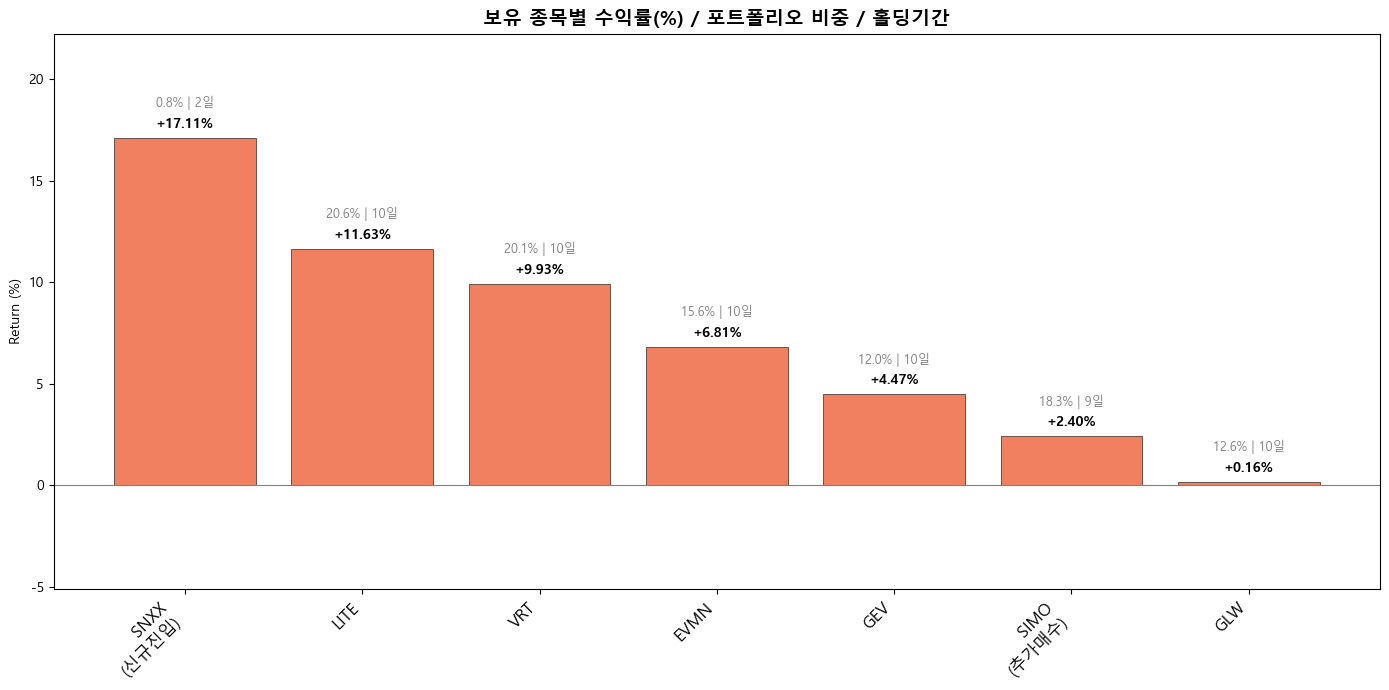

In [25]:
# Query current holdings with lot details
# daily_lots is the source of truth (derived from trade history)
# holdings is used only for current price
with conn.cursor() as cur:
    cur.execute("SELECT MAX(snapshot_date) FROM portfolio_snapshot")
    snapshot_date = cur.fetchone()[0]
    
    cur.execute("SELECT MAX(snapshot_date) FROM holdings")
    holdings_date = cur.fetchone()[0]

    # 최근 매매일 자동 탐색 (today_et가 다음 영업일로 넘어간 경우 대비)
    cur.execute(
        "SELECT MAX(trade_date) FROM account_trade_history WHERE trade_date <= %s",
        (today_et,)
    )
    last_trade_date = cur.fetchone()[0] or today_et

print(f"Snapshot date (기준일): {snapshot_date}")
print(f"Holdings date (API): {holdings_date}")
print(f"Trading date (US ET): {today_et}")
if last_trade_date != today_et:
    print(f"Last trade date: {last_trade_date} (최근 매매일 기준으로 표시)")

# 최근 매매일 기준으로 매수 종목 확인
today_buys_query = """
SELECT DISTINCT stk_cd
FROM account_trade_history
WHERE trade_date = %s AND io_tp_nm LIKE '%%매수%%'
"""

# 전일 보유 종목
prev_holdings_query = """
SELECT DISTINCT stock_code
FROM daily_lots
WHERE is_closed = FALSE AND net_quantity > 0 AND trade_date < %s
"""

# daily_lots = source of truth (built from trade history)
# LEFT JOIN holdings for current price only
holdings_query = """
SELECT
    dl.stock_code,
    dl.stock_name,
    SUM(dl.net_quantity) as total_qty,
    CASE WHEN SUM(dl.net_quantity) > 0
         THEN SUM(dl.total_cost) / SUM(dl.net_quantity)
         ELSE 0 END as avg_cost,
    COALESCE(MAX(h.cur_prc), MAX(dl.current_price)) as current_price,
    SUM(dl.unrealized_pnl) as unrealized_pnl,
    CASE WHEN SUM(dl.total_cost) > 0
         THEN ((COALESCE(MAX(h.cur_prc), MAX(dl.current_price)) * SUM(dl.net_quantity) - SUM(dl.total_cost)) / SUM(dl.total_cost)) * 100
         ELSE 0 END as return_pct,
    AVG(dl.holding_days) as avg_holding_days,
    MIN(dl.trade_date) as first_buy_date,
    COALESCE(MAX(ps.portfolio_weight_pct), 0) as weight_pct
FROM daily_lots dl
LEFT JOIN holdings h ON dl.stock_code = h.stk_cd
    AND h.snapshot_date = (SELECT MAX(snapshot_date) FROM holdings)
LEFT JOIN portfolio_snapshot ps ON dl.stock_code = ps.stock_code
    AND ps.snapshot_date = (SELECT MAX(snapshot_date) FROM portfolio_snapshot)
WHERE dl.is_closed = FALSE AND dl.net_quantity > 0
GROUP BY dl.stock_code, dl.stock_name
HAVING SUM(dl.net_quantity) > 0
ORDER BY return_pct DESC
"""

today_buys_df = pd.read_sql(today_buys_query, conn, params=(last_trade_date,))
today_buy_symbols = set(today_buys_df['stk_cd'].tolist())

prev_holdings_df = pd.read_sql(prev_holdings_query, conn, params=(last_trade_date,))
prev_holding_symbols = set(prev_holdings_df['stock_code'].tolist())

holdings_df = pd.read_sql(holdings_query, conn)

print(f"최근({last_trade_date}) 매수 종목: {today_buy_symbols if today_buy_symbols else '없음'}")
print(f"전일 보유 종목: {prev_holding_symbols}")

if holdings_df.empty:
    print("보유 종목이 없습니다.")
else:
    # 라벨 결정
    def get_label(row):
        symbol = row['stock_code'].upper()
        is_today_buy = symbol in today_buy_symbols
        was_prev_held = symbol in prev_holding_symbols
        if is_today_buy and was_prev_held:
            return f"{symbol}\n(추가매수)"
        elif is_today_buy and not was_prev_held:
            return f"{symbol}\n(신규진입)"
        else:
            return symbol

    holdings_df["display_name"] = holdings_df.apply(get_label, axis=1)

    new_buy_count = sum(1 for s in holdings_df['stock_code'] if s in today_buy_symbols and s not in prev_holding_symbols)
    add_buy_count = sum(1 for s in holdings_df['stock_code'] if s in today_buy_symbols and s in prev_holding_symbols)

    print(f"\n보유 종목: {len(holdings_df)}개 (신규진입: {new_buy_count}개, 추가매수: {add_buy_count}개)")
    print()

    # Display table
    display_holdings = holdings_df[['stock_code', 'stock_name', 'total_qty', 'avg_cost',
                                    'current_price', 'unrealized_pnl', 'return_pct', 'avg_holding_days']].copy()
    display_holdings.columns = ['종목코드', '종목명', '수량', '평균단가', '현재가', '미실현손익', '수익률(%)', '평균보유일']
    display_holdings['평균단가'] = display_holdings['평균단가'].apply(lambda x: f"${x:,.2f}" if x is not None else "N/A")
    display_holdings['현재가'] = display_holdings['현재가'].apply(lambda x: f"${x:,.2f}" if x is not None else "N/A")
    display_holdings['미실현손익'] = display_holdings['미실현손익'].apply(lambda x: f"${x:+,.2f}" if x is not None else "N/A")
    display_holdings['수익률(%)'] = display_holdings['수익률(%)'].apply(lambda x: f"{x:+.2f}%" if x is not None else "N/A")
    display_holdings['평균보유일'] = display_holdings['평균보유일'].apply(lambda x: f"{x:.0f}" if x is not None else "N/A")
    display(display_holdings)

    # Bar chart
    import numpy as np

    plot_df = holdings_df.copy()
    x = np.arange(len(plot_df))
    y = plot_df["return_pct"].fillna(0).astype(float).values
    weight = plot_df["weight_pct"].fillna(0).astype(float).values
    holding = plot_df["avg_holding_days"].fillna(0).astype(int).values
    names = plot_df["display_name"].astype(str).values

    fig, ax = plt.subplots(figsize=(max(14, len(plot_df) * 1.2), 7))

    colors = ["#f08060" if v >= 0 else "#4f7bd9" for v in y]
    bars = ax.bar(x, y, color=colors, edgecolor="black", linewidth=0.4)

    ax.axhline(0, color="gray", linewidth=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(names, rotation=45, ha="right", fontsize=12)
    ax.set_ylabel("Return (%)")
    ax.set_title("보유 종목별 수익률(%) / 포트폴리오 비중 / 홀딩기간", fontsize=14, fontweight='bold')

    ymax = float(np.nanmax(y)) if len(y) > 0 else 10
    ymin = float(np.nanmin(y)) if len(y) > 0 else -10
    ymax = max(ymax, 0)
    ymin = min(ymin, 0)
    y_range = ymax - ymin if (ymax - ymin) > 0 else 10
    pad = max(y_range * 0.30, 3.0)
    ax.set_ylim(ymin - pad, ymax + pad)

    for bar, ret, w, days in zip(bars, y, weight, holding):
        cx = bar.get_x() + bar.get_width() / 2
        sign = 1 if ret >= 0 else -1
        va = "bottom" if ret >= 0 else "top"

        # 수익률 (막대 바로 위/아래)
        ax.text(cx, ret + sign * y_range * 0.02, f"{ret:+.2f}%",
                ha="center", va=va, fontsize=10, fontweight="bold")

        # 비중 + 홀딩기간 (그 위/아래, 한 줄로)
        ax.text(cx, ret + sign * y_range * 0.08, f"{w:.1f}% | {days}일",
                ha="center", va=va, fontsize=9, color="gray")

    plt.tight_layout()
    plt.show()

## 4. 포트폴리오 vs S&P500/NASDAQ 수익률 비교 (TWR/MWR)

In [26]:
def calculate_twr(daily_values: pd.Series) -> float:
    """
    Calculate Time-Weighted Return (TWR)
    TWR = Product of (1 + daily_return) - 1
    """
    if len(daily_values) < 2:
        return 0.0
    
    daily_returns = daily_values.pct_change().dropna()
    twr = ((1 + daily_returns).prod() - 1) * 100
    return twr

def calculate_mwr(cashflows: list, final_value: float, initial_value: float, periods: int) -> float:
    """
    Calculate Money-Weighted Return (MWR) using simplified IRR
    For simple approximation: MWR ≈ (Final - Initial - Net Cashflows) / Average Capital
    """
    if initial_value == 0 or periods == 0:
        return 0.0
    
    net_cashflows = sum(cf for cf, _ in cashflows)
    gain = final_value - initial_value - net_cashflows
    avg_capital = (initial_value + final_value) / 2
    
    if avg_capital == 0:
        return 0.0
    
    # Annualized return
    mwr = (gain / avg_capital) * (365 / periods) * 100 if periods > 0 else 0
    return mwr

분석 기간: 2026-02-01 ~ 2026-02-23 (US ET)
Synced 14 market index records from 2026-02-01 to 2026-02-23
시장 지수 동기화: 14개 레코드
  실시간 데이터 갱신 (2026-02-20): $27,914.46 → $28,075.06
=== 수익률 비교 (기간: 2026-02-02 ~ 2026-02-20) ===

TWR (Time-Weighted Return):
  포트폴리오: +2.31%
  S&P 500:    -0.96%
  NASDAQ:     -2.99%

Alpha (초과수익률):
  vs S&P 500: +3.27%p
  vs NASDAQ:  +5.31%p


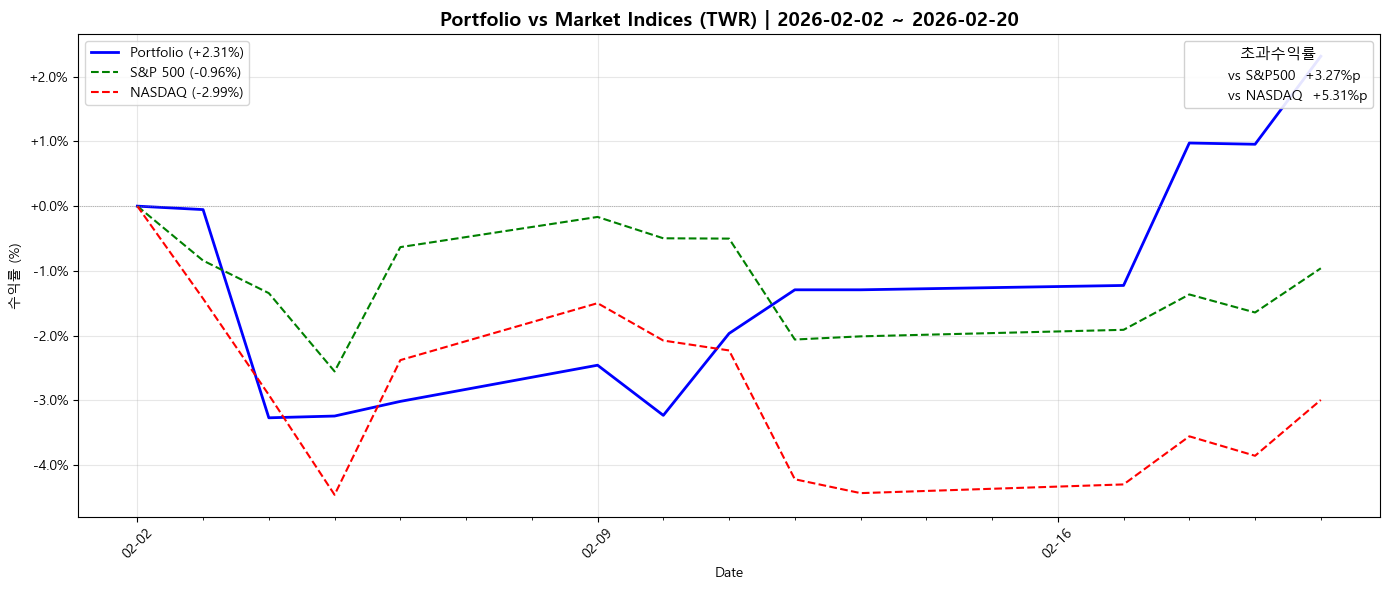

In [27]:
# Reconnect if connection was lost
try:
    conn.ping(reconnect=True)
except:
    conn = get_connection()
    print("DB reconnected")

# ============================================================
# 설정: 분석 기간 (원하는 날짜로 변경하세요)
# ============================================================
START_DATE = date(2026, 2, 1)
END_DATE = today_et  # 오늘(US ET) 또는 date(2026, 2, 1) 등
# ============================================================

print(f"분석 기간: {START_DATE} ~ {END_DATE} (US ET)")

# Portfolio daily values
portfolio_hist_query = """
SELECT 
    snapshot_date,
    total_asset_usd as portfolio_value
FROM daily_portfolio_snapshot
WHERE snapshot_date >= %s AND snapshot_date <= %s
ORDER BY snapshot_date
"""

portfolio_hist = pd.read_sql(portfolio_hist_query, conn, params=(START_DATE, END_DATE))

# Market index data
market_query = """
SELECT 
    index_date,
    sp500_close,
    nasdaq_close
FROM market_index
WHERE index_date >= %s AND index_date <= %s
ORDER BY index_date
"""

market_hist = pd.read_sql(market_query, conn, params=(START_DATE, END_DATE))

# Auto-sync market index only if DB data is missing or stale (3+ business days old)
need_sync = market_hist.empty
if not need_sync and not market_hist.empty:
    latest_market_in_db = pd.to_datetime(market_hist['index_date']).max().date()
    need_sync = (END_DATE - latest_market_in_db).days >= 3

if need_sync:
    try:
        from services.market_index_service import sync_market_index
        sync_count = sync_market_index(conn, start_date=START_DATE, end_date=END_DATE)
        if sync_count > 0:
            market_hist = pd.read_sql(market_query, conn, params=(START_DATE, END_DATE))
            print(f"시장 지수 동기화: {sync_count}개 레코드")
    except Exception as e:
        if market_hist.empty:
            print(f"시장 지수 동기화 실패: {e}")

if portfolio_hist.empty:
    print(f"포트폴리오 히스토리 데이터가 없습니다. (기간: {START_DATE} ~ {END_DATE})")
    print("daily_portfolio_snapshot 테이블을 확인하세요.")
elif market_hist.empty:
    print(f"시장 지수 데이터를 불러올 수 없습니다.")
else:
    # Convert to date-only (strip time component)
    portfolio_hist['snapshot_date'] = pd.to_datetime(portfolio_hist['snapshot_date']).dt.normalize()
    market_hist['index_date'] = pd.to_datetime(market_hist['index_date']).dt.normalize()
    
    # Deduplicate: keep last value per day
    portfolio_hist = portfolio_hist.groupby('snapshot_date', as_index=False).last()
    market_hist = market_hist.groupby('index_date', as_index=False).last()
    
    # === 실시간 데이터 보정: 최신 총자산을 cell-5의 real-time 값으로 갱신 ===
    try:
        realtime_total = total_value  # cell-5에서 계산한 현금+주식 실시간 값
        latest_market = market_hist['index_date'].max()
        latest_portfolio = portfolio_hist['snapshot_date'].max()
        
        if latest_market > latest_portfolio:
            # 시장 데이터는 있는데 포트폴리오 스냅샷이 없는 날 → 추가
            new_row = pd.DataFrame({
                'snapshot_date': [latest_market],
                'portfolio_value': [realtime_total]
            })
            portfolio_hist = pd.concat([portfolio_hist, new_row], ignore_index=True)
            print(f"  실시간 데이터 추가 ({latest_market.date()}): ${realtime_total:,.2f}")
        else:
            # 최신 날짜의 값을 실시간으로 갱신
            old_val = portfolio_hist.loc[
                portfolio_hist['snapshot_date'] == latest_portfolio, 'portfolio_value'
            ].iloc[0]
            portfolio_hist.loc[
                portfolio_hist['snapshot_date'] == latest_portfolio, 'portfolio_value'
            ] = realtime_total
            if abs(old_val - realtime_total) > 1:
                print(f"  실시간 데이터 갱신 ({latest_portfolio.date()}): ${old_val:,.2f} → ${realtime_total:,.2f}")
    except NameError:
        print("  [INFO] 실시간 보정 생략 (cell 5 미실행)")
    
    # Merge data
    merged = portfolio_hist.merge(
        market_hist,
        left_on='snapshot_date',
        right_on='index_date',
        how='inner'
    )
    
    if merged.empty:
        print("포트폴리오와 시장 지수 데이터가 겹치지 않습니다.")
    else:
        # Calculate TWR
        portfolio_twr = calculate_twr(merged['portfolio_value'])
        sp500_twr = calculate_twr(merged['sp500_close'])
        nasdaq_twr = calculate_twr(merged['nasdaq_close'])
        
        actual_start = merged['snapshot_date'].min().date()
        actual_end = merged['snapshot_date'].max().date()
        
        # Alpha (초과수익률)
        alpha_vs_sp500 = portfolio_twr - sp500_twr
        alpha_vs_nasdaq = portfolio_twr - nasdaq_twr
        
        print(f"=== 수익률 비교 (기간: {actual_start} ~ {actual_end}) ===")
        print(f"\nTWR (Time-Weighted Return):")
        print(f"  포트폴리오: {portfolio_twr:+.2f}%")
        print(f"  S&P 500:    {sp500_twr:+.2f}%")
        print(f"  NASDAQ:     {nasdaq_twr:+.2f}%")
        print(f"\nAlpha (초과수익률):")
        print(f"  vs S&P 500: {alpha_vs_sp500:+.2f}%p")
        print(f"  vs NASDAQ:  {alpha_vs_nasdaq:+.2f}%p")
        
        # Calculate return % (base 0%)
        merged['portfolio_ret'] = (merged['portfolio_value'] / merged['portfolio_value'].iloc[0] - 1) * 100
        merged['sp500_ret'] = (merged['sp500_close'] / merged['sp500_close'].iloc[0] - 1) * 100
        merged['nasdaq_ret'] = (merged['nasdaq_close'] / merged['nasdaq_close'].iloc[0] - 1) * 100
        
        # ── Line Chart with Alpha Legend ──
        import matplotlib.dates as mdates
        from matplotlib.ticker import FuncFormatter
        from matplotlib.patches import Patch
        
        fig, ax = plt.subplots(figsize=(14, 6))
        
        dates = merged['snapshot_date']
        
        ax.plot(dates, merged['portfolio_ret'], 
                label=f'Portfolio ({portfolio_twr:+.2f}%)', linewidth=2, color='blue')
        ax.plot(dates, merged['sp500_ret'], 
                label=f'S&P 500 ({sp500_twr:+.2f}%)', linewidth=1.5, linestyle='--', color='green')
        ax.plot(dates, merged['nasdaq_ret'], 
                label=f'NASDAQ ({nasdaq_twr:+.2f}%)', linewidth=1.5, linestyle='--', color='red')
        
        ax.axhline(y=0, color='gray', linewidth=0.5, linestyle=':')
        ax.set_xlabel('Date')
        ax.set_ylabel('수익률 (%)')
        ax.set_title(f'Portfolio vs Market Indices (TWR) | {actual_start} ~ {actual_end}', 
                      fontsize=14, fontweight='bold')
        
        # Main legend (좌측)
        legend1 = ax.legend(loc='upper left')
        
        # Alpha legend (우측)
        alpha_handles = [
            Patch(facecolor='none', edgecolor='none', 
                  label=f'vs S&P500  {alpha_vs_sp500:+.2f}%p'),
            Patch(facecolor='none', edgecolor='none', 
                  label=f'vs NASDAQ  {alpha_vs_nasdaq:+.2f}%p'),
        ]
        legend2 = ax.legend(handles=alpha_handles, loc='upper right', 
                            title='초과수익률', framealpha=0.9, 
                            title_fontsize=11, fontsize=10)
        ax.add_artist(legend1)  # 첫 번째 legend 다시 추가
        
        ax.grid(True, alpha=0.3)
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:+.1f}%'))
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
        ax.xaxis.set_minor_locator(mdates.DayLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

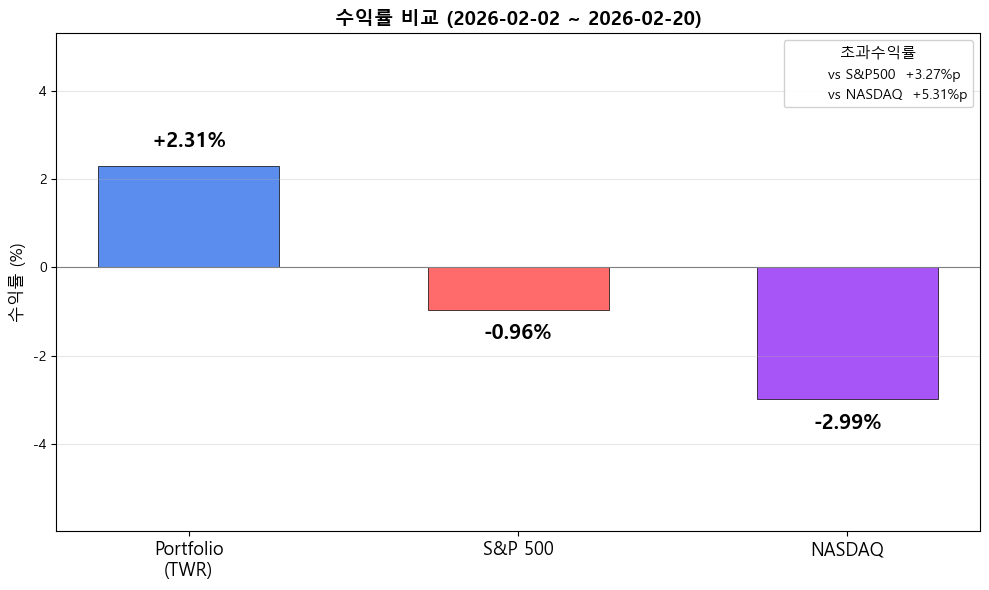

In [28]:
# ── 수익률 비교 Bar Chart (with Alpha Legend) ──
import numpy as np
from matplotlib.patches import Patch

returns = {
    'Portfolio\n(TWR)': portfolio_twr,
    'S&P 500': sp500_twr,
    'NASDAQ': nasdaq_twr,
}

fig2, ax2 = plt.subplots(figsize=(10, 6))

x = np.arange(len(returns))
values = list(returns.values())
bar_colors = ['#5B8DEF', '#FF6B6B', '#A855F7']

bars = ax2.bar(x, values, color=bar_colors, edgecolor='black', linewidth=0.5, width=0.55)

ax2.axhline(0, color='gray', linewidth=0.8)
ax2.set_xticks(x)
ax2.set_xticklabels(returns.keys(), fontsize=13)
ax2.set_ylabel('수익률 (%)', fontsize=12)
ax2.set_title(f'수익률 비교 ({actual_start} ~ {actual_end})', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# 값 표시
for bar, val in zip(bars, values):
    height = bar.get_height()
    offset = 0.3 if height >= 0 else -0.3
    ax2.text(bar.get_x() + bar.get_width() / 2, height + offset,
             f'{val:+.2f}%', ha='center',
             va='bottom' if height >= 0 else 'top',
             fontsize=15, fontweight='bold')

# Alpha legend (우측)
alpha_handles = [
    Patch(facecolor='none', edgecolor='none', 
          label=f'vs S&P500  {alpha_vs_sp500:+.2f}%p'),
    Patch(facecolor='none', edgecolor='none', 
          label=f'vs NASDAQ  {alpha_vs_nasdaq:+.2f}%p'),
]
ax2.legend(handles=alpha_handles, loc='upper right', title='초과수익률',
           framealpha=0.9, title_fontsize=11, fontsize=10)

# y축 범위 조정
ymax = max(max(values), 0) + 3
ymin = min(min(values), 0) - 3
ax2.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

## 5. 요약 테이블 (Summary Table)

In [29]:
# Get summary statistics
summary_query = """
SELECT
    (SELECT COUNT(DISTINCT stock_code) FROM daily_lots WHERE is_closed = FALSE) as open_positions,
    (SELECT COUNT(*) FROM daily_lots WHERE is_closed = FALSE) as total_lots,
    (SELECT COALESCE(SUM(total_cost), 0) FROM daily_lots WHERE is_closed = FALSE) as total_invested,
    (SELECT COALESCE(SUM(unrealized_pnl), 0) FROM daily_lots WHERE is_closed = FALSE) as total_unrealized_pnl,
    (SELECT COALESCE(SUM(realized_pnl), 0) FROM daily_lots WHERE is_closed = TRUE) as total_realized_pnl,
    (SELECT COUNT(*) FROM daily_lots WHERE is_closed = TRUE) as closed_lots,
    (SELECT AVG(holding_days) FROM daily_lots WHERE is_closed = FALSE) as avg_holding_days_open,
    (SELECT AVG(holding_days) FROM daily_lots WHERE is_closed = TRUE) as avg_holding_days_closed
"""

with conn.cursor() as cur:
    cur.execute(summary_query)
    result = cur.fetchone()

open_positions = result[0] or 0
total_lots = result[1] or 0
total_invested = float(result[2] or 0)
total_unrealized_pnl = float(result[3] or 0)
total_realized_pnl = float(result[4] or 0)
closed_lots = result[5] or 0
avg_holding_open = result[6] or 0
avg_holding_closed = result[7] or 0

unrealized_return = (total_unrealized_pnl / total_invested * 100) if total_invested > 0 else 0

print("=" * 60)
print("              US Stock Portfolio Summary")
print("=" * 60)
print()
print(f"현재 보유 종목 수:     {open_positions}개")
print(f"현재 보유 Lot 수:      {total_lots}개")
print(f"총 투자금액:           ${total_invested:,.2f}")
print()
print(f"미실현 손익:           ${total_unrealized_pnl:+,.2f}")
print(f"미실현 수익률:         {unrealized_return:+.2f}%")
print()
print(f"총 실현 손익:          ${total_realized_pnl:+,.2f}")
print(f"청산 Lot 수:           {closed_lots}개")
print()
print(f"보유 종목 평균 보유일: {avg_holding_open:.1f}일")
print(f"청산 종목 평균 보유일: {avg_holding_closed:.1f}일")
print()
print("=" * 60)

              US Stock Portfolio Summary

현재 보유 종목 수:     7개
현재 보유 Lot 수:      13개
총 투자금액:           $26,228.37

미실현 손익:           $+1,686.09
미실현 수익률:         +6.43%

총 실현 손익:          $-416.83
청산 Lot 수:           26개

보유 종목 평균 보유일: 9.3일
청산 종목 평균 보유일: 3.6일



In [30]:
# Close connection
conn.close()
print("Database connection closed.")

Database connection closed.
